# Step 1: Importing the Libraries


In [1]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import List, Dict
import torch.optim as optim
from PIL import Image
import torch.nn as nn
import numpy as np
import torch
import os

# Step 2: Select Dataset, Save Directories, and Device

By default, the global variables will work. If you wish to modify settings, then set the following global variables at the top of the script:


*   mode = 'train' (set to 'load' if resuming from a checkpoint). Note that if running for the first time, you must set mode = 'train', as your current environment does not have any model checkpoints saved.
*   dataset = 'CIFAR10' (or 'MNIST')
*   torch_save_dir = r"model.pth" (specify model save location)


In [2]:
mode = 'train' # 'train' or 'load'
dataset = 'CIFAR10' # 'CIFAR10' or 'MNIST'
torch_save_dir = r"model.pth" # Choose where to save the model
CIFAR_testing_dir = r"" # Choose the directory to classify any user inputted image within CIFAR-10 classes. If none, then leave blank.
MNIST_testing_dir = r"" # Choose the directory to classify any user inputted image within MNIST classes. If none, then leave blank.

if torch.cuda.is_available(): # Use GPU if available, else CPU
    device = torch.device("cuda")
    print("Cuda is available. Code will default to GPU.")
else:
    device = torch.device("cpu")
    print("Cuda not available! Code will default to CPU.")
if dataset != 'CIFAR10' and dataset != 'MNIST':
    print(f"Please select a valid dataset!")
if mode == 'load':
    print(f"Script is currently in '{mode}' mode. Please note this will skip the training process and use the last model checkpoint saved.\n")
elif mode == 'train':
    print(f"Script is currently in '{mode}' mode. Please note this will train the model from scratch and overwrite the previous model checkpoint.")
    print(f"The model will proceed to train on {dataset}.\n")
else:
    print(f"Please enter a valid mode (either 'train' or 'load')!")
    quit()

Cuda is available. Code will default to GPU.
Script is currently in 'train' mode. Please note this will train the model from scratch and overwrite the previous model checkpoint.
The model will proceed to train on CIFAR10.



# Step 3: Define a Positional Encoding Class
This is used to provide positional information to sequences ViTs. This step is crucial for the model to understand the spatial relationships between different parts of the input.

Parameters are:
- d_model: The dimensionality of the embeddings (i.e., the size of each positional encoding).
- max_len: The maximum length of input sequences (or number of patches in an image).


**Note: This code was used in Assignment 4 in ECE 57000.**

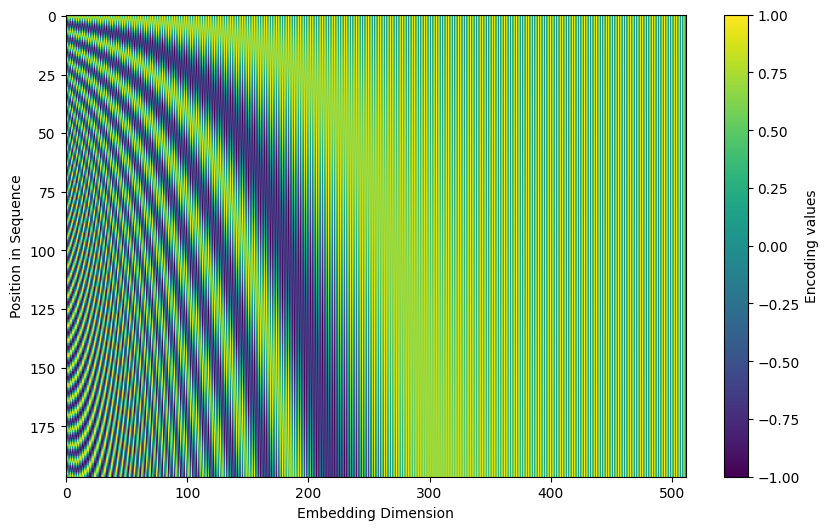

In [3]:
class PositionalEncoding:
    def __init__(self, d_model, max_len):
        self.d_model = d_model
        self.max_len = max_len
        self.encoding = self._get_positional_encoding()
    def _get_positional_encoding(self):
        positional_encoding = np.zeros((self.max_len, self.d_model))
        for pos in range(self.max_len):
            for i in range(0, self.d_model, 2):
              positional_encoding[pos, i] = np.sin(pos / (10000 ** (i / self.d_model)))
              if i + 1 < self.d_model:
                positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** (i / self.d_model)))
        return positional_encoding
    def add_positional_encoding(self, input_tensor, positional_encodings):
        return input_tensor + torch.tensor(positional_encodings).clone().detach().to(input_tensor.device)

def visualize_positional_encoding(PE):
    plt.figure(figsize=(10, 6))
    plt.imshow(PE, aspect='auto', cmap='viridis')
    plt.colorbar(label="Encoding values")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Position in Sequence")
    plt.savefig("positional_encoding.png")
    plt.show()
    plt.close()
d_model = 512
max_len = (224 // 16) ** 2 + 1
positional_encoding = PositionalEncoding(d_model, max_len)
visualize_positional_encoding(positional_encoding._get_positional_encoding())

# Step 4: Define Multi-Head Self-Attention

This is a a key component of transformer architectures, which allows them to focus on different parts of an input sequence when making predictions. Self-attention allows a model to weigh the importance of different tokens relative to one another. It computes attention scores that dictate how much focus to place on each token while encoding a specific token. For a given input sequence, self-attention calculates three vectors for each token: Query (Q), Key (K), and Value (V):
$$
\operatorname{A}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V,
$$

The attention scores are computed using these vectors. Instead of performing a single self-attention operation, multi-head attention runs several self-attention mechanisms in parallel (the "heads"). Each head learns to focus on different aspects of the input sequence.

The equation was used in Assignment 4, but the code has been changed.


In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        if embedding_dim % num_heads != 0:
          print("Embedding dimension must be divisible by num_heads")
          quit()
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.out = nn.Linear(embedding_dim, embedding_dim)
    def forward(self, input_tensor):
        batch_size, seq_len, embedding_dim = input_tensor.size()
        query = self.query(input_tensor).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key(input_tensor).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value(input_tensor).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, value).transpose(1, 2).contiguous().view(batch_size, seq_len, embedding_dim)
        return self.out(attention_output)

# Step 5: Define a Transformer Encoder Block and Multi-Layer Perceptron (MLP)

This cell defines a Transformer Encoder Block which consists of two main components: a multi-head self-attention layer and a feed-forward neural network (MLP). This is structured based on the architecture presented in the paper.

* Multi-Head Self-Attention: The input tensor is first passed through the multi-headself-attention mechanism.
* Layer Normalization: The input is first normalized using LayerNorm and residual connections are applied
* Feed-Forward Neural Network (MLP): A sequential MLP with two linear layers and a GELU activation is applied after the attention block, followed by another LayerNorm and residual connection.

In [5]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dim):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(nn.Linear(embedding_dim, mlp_dim), nn.GELU(), nn.Linear(mlp_dim, embedding_dim))
        self.norm2 = nn.LayerNorm(embedding_dim)
    def forward(self, input_tensor):
        x = self.norm1(input_tensor + self.attention(input_tensor))
        return self.norm2(x + self.mlp(x))

# Step 6: Define the Vision Transformer

Now, we put everything together by following the paper:

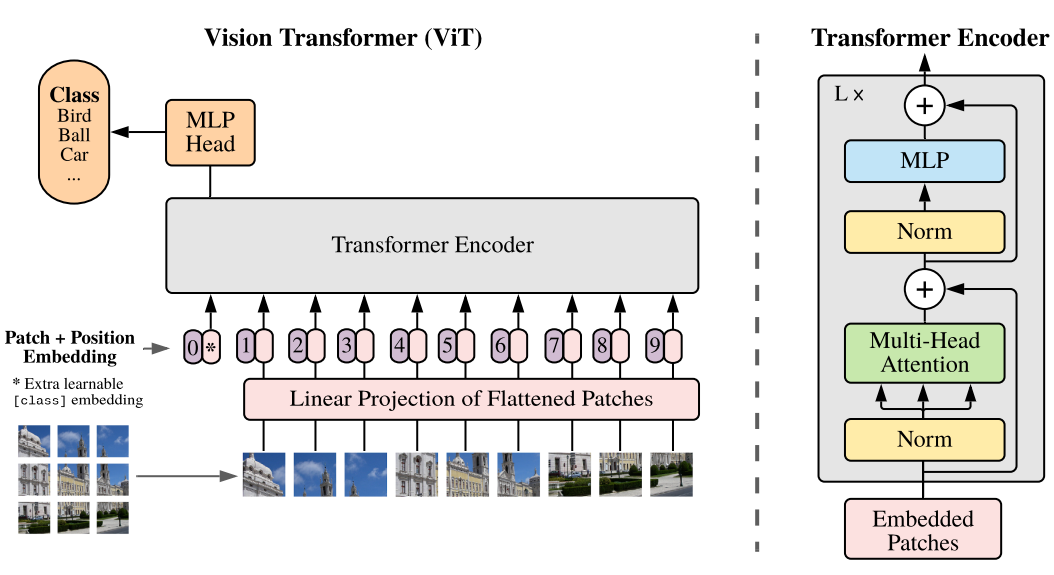

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_heads, num_layers, mlp_dim, image_size=224):
        super(VisionTransformer, self).__init__()
        # Initialize variables
        self.image_size = image_size
        self.patch_size = 16
        self.num_patches = (image_size // self.patch_size) ** 2
        self.embedding_dim = embedding_dim
        # First split into 16x16 patches
        in_channels = 3 if dataset == 'CIFAR10' else 1
        self.conv_projection = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=self.patch_size, stride=self.patch_size)
        # Then add positional encoding
        self.positional_encoding = torch.tensor(PositionalEncoding(embedding_dim, self.num_patches + 1).encoding, dtype=torch.float32)
        # Then add the class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        # Now feed into transformer encoder block
        self.encoder_blocks = nn.ModuleList([TransformerEncoderBlock(embedding_dim, num_heads, mlp_dim) for _ in range(num_layers)])
        # Pass through MLP head
        self.mlp_head = nn.Sequential(nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, num_classes))

    def forward(self, x):
        # Project the input image into patch embeddings
        x = self.conv_projection(x).flatten(2).transpose(1, 2) # Flatten and transpose to [batch_size, sequence_length, feature_dimension]
        # Append class token to embeddings
        batch_size = x.size(0)
        expanded_class_token = self.class_token.expand(batch_size, -1, -1)
        embeddings_with_class_token = torch.cat((expanded_class_token, x), dim=1)
        embeddings = embeddings_with_class_token + self.positional_encoding.unsqueeze(0).to(embeddings_with_class_token.device)
        # Pass the embeddings through Transformer encoder blocks
        for encoder_block in self.encoder_blocks:
            embeddings = encoder_block(embeddings)
        # Output the class token embedding after the last encoder block
        return self.mlp_head(embeddings[:, 0])

# Step 7: Define Data Augmentation (MixUp and CutMix) Functions

This reimplementation utilizes MixUp and CutMix augmentation functions to see how it affects the training of a Vision Transformer.

## MixUp
Mixup is a data augmentation technique where two samples (images and labels) are mixed together.

The Mixup equation for an image x and its label y is:
\begin{equation}
\tilde{x} = \lambda x_1 + (1 - \lambda) x_2
\end{equation}
\begin{equation}
\tilde{y} = \lambda y_1 + (1 - \lambda) y_2
\end{equation}

Where $\lambda \sim \text{Beta}(\alpha, \alpha)$

## CutMix
CutMix is another augmentation where a patch from one image is cut and pasted into another image, and the labels are also mixed according to the area ratio of the patch.

The equations used for CutMix are:
\begin{equation}
\text{Cut}_W = W \cdot \sqrt{1 - \lambda}
\end{equation}

\begin{equation}
\text{Cut}_H = H \cdot \sqrt{1 - \lambda}
\end{equation}

\begin{equation}
1 - \lambda' = \frac{r_w r_h}{W \cdot H}
\end{equation}

Where $\lambda \sim \text{Beta}(\alpha, \alpha)$


**Note: Due to random operations (e.g., sampling from a Beta distribution, selecting images, and generating cut coordinates), the output will vary with each run. For MixUp, you'll see a blend of colors based on λ, and for CutMix, one image will be overlaid onto another by the factor λ.**


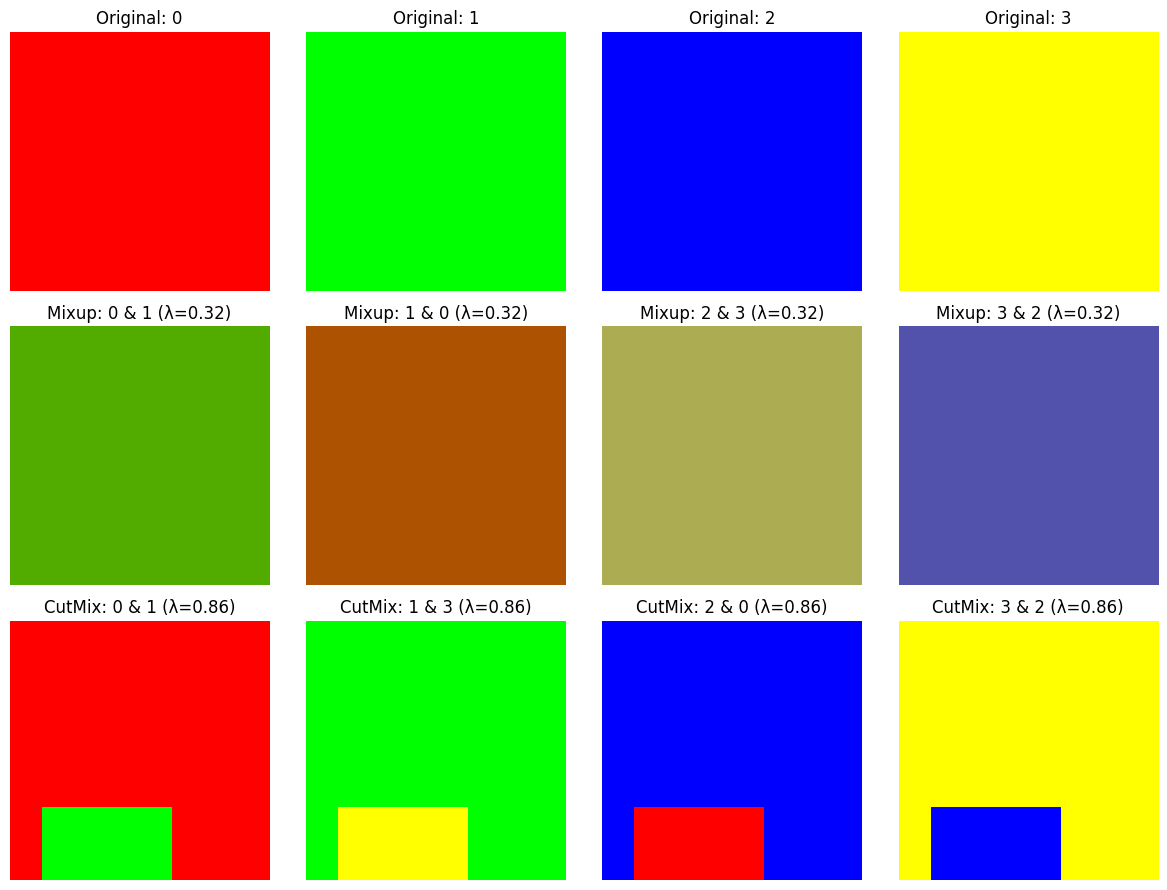

In [7]:
def mixup_data(images, targets, alpha=0.4):
    # lambda is from the beta distribution Beta(α, α)
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    # This will be used to select a different image for mixing.
    index = torch.randperm(images.size(0)).to(images.device)
    # The mixing formula is: mixed_images = lam * images + (1 - lam) * images[index]
    mixed_images = lam * images + (1 - lam) * images[index, :]
    return mixed_images, targets, targets[index], lam

def cutmix_data(images, targets, alpha=1.0):\
    # lambda is from the beta distribution Beta(α, α)
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    # This will be used to select a different image for mixing.
    index = torch.randperm(images.size(0), device=images.device)
    # Get image size
    _, _, H, W = images.size()
    # r_w, r_h = W*sqrt(1-lam), H*sqrt(1-lam)
    cut_w, cut_h = int(W * np.sqrt(1. - lam)), int(H * np.sqrt(1. - lam))
    # Center coordinates of the cut region
    cx, cy = torch.randint(0, W, (1,), device=images.device).item(), torch.randint(0, H, (1,), device=images.device).item()
    # Re-calculate to capture boundaries
    x1, x2 = max(cx - cut_w // 2, 0), min(cx + cut_w // 2, W)
    y1, y2 = max(cy - cut_h // 2, 0), min(cy + cut_h // 2, H)
    # Combine images
    images[:, :, y1:y2, x1:x2] = images[index, :, y1:y2, x1:x2]
    # lambda' = 1 - (r_w*r_h / W*H)
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    return images, targets, targets[index], lam


# Visualize MixUp and CutMix using solid colors
batch_size, channels, height, width = 4, 3, 32, 32
colors = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0],  # Blue
    [1.0, 1.0, 0.0],  # Yellow
]).view(batch_size, channels, 1, 1)
images = colors.expand(batch_size, channels, height, width)
targets = torch.arange(batch_size)
mixup_images, mixup_targets_a, mixup_targets_b, mixup_lam = mixup_data(images.clone(), targets, alpha=0.4)
cutmix_images, cutmix_targets_a, cutmix_targets_b, cutmix_lam = cutmix_data(images.clone(), targets, alpha=1.0)
fig, axs = plt.subplots(3, batch_size, figsize=(12, 9))
for i in range(batch_size):
    axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
    axs[0, i].set_title(f"Original: {targets[i].item()}")
    axs[0, i].axis('off')
    axs[1, i].imshow(mixup_images[i].permute(1, 2, 0).cpu().numpy())
    axs[1, i].set_title(f"Mixup: {mixup_targets_a[i].item()} & {mixup_targets_b[i].item()} (λ={mixup_lam:.2f})")
    axs[1, i].axis('off')
    axs[2, i].imshow(cutmix_images[i].permute(1, 2, 0).cpu().numpy())
    axs[2, i].set_title(f"CutMix: {cutmix_targets_a[i].item()} & {cutmix_targets_b[i].item()} (λ={cutmix_lam:.2f})")
    axs[2, i].axis('off')
plt.tight_layout()
plt.savefig("augmentation_sample.png")
plt.show()
plt.close()


# Step 8: Define Train and Test Functions
Here, the train and test functions are defined. The train function applies both Cutmix and Mixup augmentation during training with 50/50 chance of either or on each iteration. It also keeps track of the train/test accuracies and loss for our plot analysis later on.

**Note: These are modified train and test functions from Assignment 3.**

In [8]:
train_accuracies = []
train_losses = []
def train(model: nn.Module, criterion: nn.modules.loss._Loss, optimizer: torch.optim.Optimizer, train_loader: torch.utils.data.DataLoader, epoch: int = 0, alpha: float = 0.4) -> List:
    model.to(device)
    model.train()
    scaler = torch.amp.GradScaler(init_scale=2.**16, device='cuda')
    total_loss = 0.0
    total_correct, total_samples = 0, 0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        # Randomly pick between CutMix or MixUp
        if np.random.rand() < 0.5:
            mixed_images, targets_a, targets_b, lam = cutmix_data(images, targets, alpha=alpha)
        else:
            mixed_images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=alpha)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Calculate accuracy for both sets of targets
        _, predicted = torch.max(outputs, 1)
        accuracy_a = (predicted == targets_a).float().sum().item()
        accuracy_b = (predicted == targets_b).float().sum().item()
        batch_accuracy = lam * (accuracy_a / len(targets_a)) + (1 - lam) * (accuracy_b / len(targets_b))
        total_loss += loss.item()
        total_correct += (lam * accuracy_a + (1 - lam) * accuracy_b)
        total_samples += len(targets)
        if batch_idx % (len(train_loader) // 9) == 0:  # Print 9 times per epoch
            print(f'Epoch {epoch}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Train Loss: {loss.item():.3f} | Train Accuracy: {100 * batch_accuracy:.3f}%')
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = 100 * (total_correct / total_samples)
    train_losses.append(avg_loss) # Record training losses
    train_accuracies.append(avg_accuracy) # Record training accuracies
    print('---------------------------------------- --------------------------')
    print(f'Train Result for Epoch {epoch}: Avg Train Loss: {avg_loss:.3f} | Avg Train Accuracy: {avg_accuracy:.3f}%')

test_accuracies = []
test_losses = []
def test(model: nn.Module, criterion: nn.modules.loss._Loss, test_loader: torch.utils.data.DataLoader, epoch: int=0) -> Dict:
    model.to(device)
    model.eval()
    test_loss, correct = 0, 0
    total_num = len(test_loader.dataset)
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, targets).item() * len(images)
            correct += (outputs.argmax(1) == targets).sum().item()
    avg_loss = test_loss / total_num
    accuracy = 100 * (correct / total_num)
    test_losses.append(avg_loss) # Record testing losses
    test_accuracies.append(accuracy) # Record testing accuracies
    print(f"Test Result for Epoch {epoch}: Avg Test Loss: {avg_loss:.3f} | Avg Test Accuracy: {accuracy:.3f}%")

# Step 9: Data Preparation and Visualization for CIFAR10 Dataset

Here, we load CIFAR-10 or MNIST datasets, similar to what was done in Assignment 3.

In [9]:
if dataset == 'CIFAR10':
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transform)
if dataset == 'MNIST':
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=1, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=False, pin_memory=True)

# Visualize Cifar
if dataset == "CIFAR10":
    classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
elif dataset == "MNIST":
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
plt.savefig("sample_images.png")
plt.close(fig)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Step 10: Define the ViT Model

Here we define the ViT model with the specified parameters.

In [10]:
# DEFINE THE VIT MODEL
num_patches = (224 // 16) ** 2
num_classes = 10
num_heads = 8
num_layers = 8
mlp_dim = 2048
VIT_model = VisionTransformer(d_model, num_classes, num_heads, num_layers, mlp_dim)

# Step 11: Train the ViT model
The output below shows the results after 5 epochs (which is not sufficient enough for a moderately sized ViT). However, you should expect around 70% test accuracy after just 5 epochs. To achieve greater accuracy, increase the number of epochs.

**Note: Please ensure you have sufficient compute units on Google Colab to run on higher epochs!**


In [11]:
if mode == 'train':
    num_epochs = 5
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(VIT_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    learning_rates = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        learning_rates.append(optimizer.param_groups[0]["lr"]) # Record learning rate schedule
        train(VIT_model, criterion, optimizer, train_loader, epoch) # Train
        test(VIT_model, criterion, test_loader, epoch) # Test
        current_val_loss = test_losses[-1] # Determine the best loss to save it as a model checkpoint
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            torch.save(VIT_model.state_dict(), torch_save_dir)
            print(f"** Optimal Checkpoint Saved with Validation Loss: {best_val_loss:.3f} **")
        scheduler.step()

Epoch 0: [0/50000] Train Loss: 2.486 | Train Accuracy: 12.500%
Epoch 0: [5536/50000] Train Loss: 1.941 | Train Accuracy: 33.729%
Epoch 0: [11072/50000] Train Loss: 2.217 | Train Accuracy: 18.912%
Epoch 0: [16608/50000] Train Loss: 2.121 | Train Accuracy: 25.819%
Epoch 0: [22144/50000] Train Loss: 2.046 | Train Accuracy: 26.309%
Epoch 0: [27680/50000] Train Loss: 1.779 | Train Accuracy: 38.129%
Epoch 0: [33216/50000] Train Loss: 1.472 | Train Accuracy: 59.360%
Epoch 0: [38752/50000] Train Loss: 1.859 | Train Accuracy: 34.901%
Epoch 0: [44288/50000] Train Loss: 1.582 | Train Accuracy: 40.623%
Epoch 0: [49824/50000] Train Loss: 1.848 | Train Accuracy: 35.581%
---------------------------------------- --------------------------
Train Result for Epoch 0: Avg Train Loss: 1.971 | Avg Train Accuracy: 28.872%
Test Result for Epoch 0: Avg Test Loss: 1.495 | Avg Test Accuracy: 46.830%
** Optimal Checkpoint Saved with Validation Loss: 1.495 **
Epoch 1: [0/50000] Train Loss: 1.402 | Train Accuracy: 

# Step 12: Plot Learning Curves
Includes:
- Loss Curves (Train and Test)
- Accuracy Curves (Train and Test)
- Learning Rate Schedule Curve

**Note: For more cohesive plots, run on higher epochs for more sampling points.**

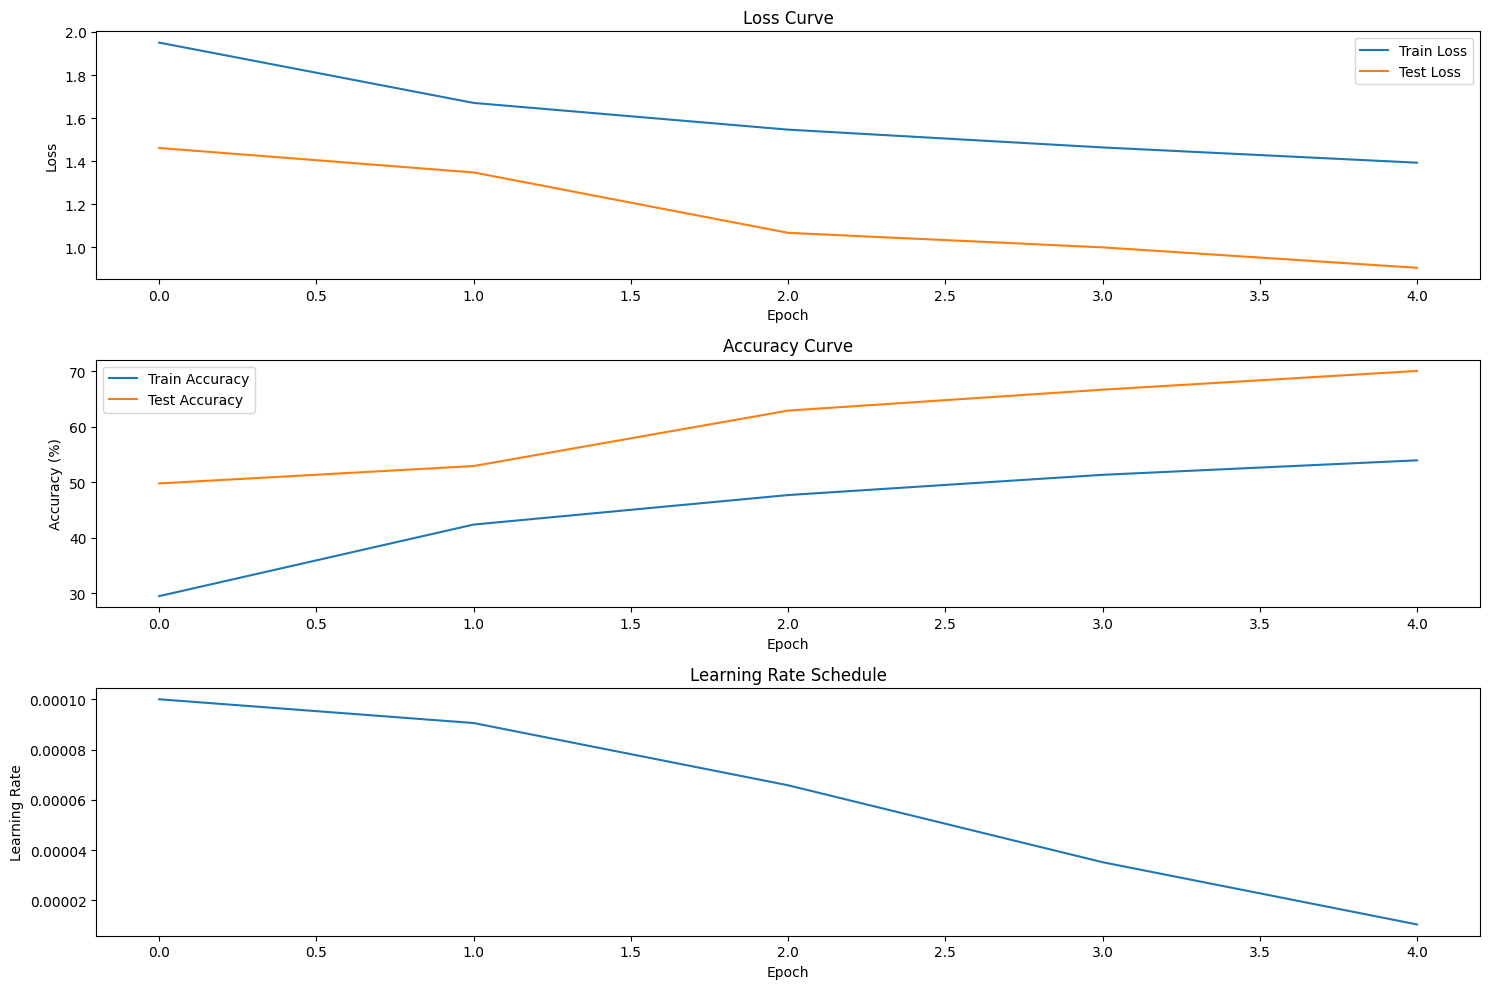

In [ ]:
if mode == 'train':
    plt.figure(figsize=(15, 10))
    # Plot Train and Test Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    # Plot Train and Test Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")
    # Plot Learning Rate
    plt.subplot(3, 1, 3)
    plt.plot(learning_rates)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    # Save the plots
    plt.tight_layout()
    plt.savefig("learning_plots.png")
    plt.show()
    plt.close()

# Optional: Real-World Testing
Observe the model's behavior by inputting images found online and see if it can successfully classify the image.


**Note: To run this code cell, ensure that the global variables ```CIFAR_testing_dir``` or ```MNIST_testing_dir``` are set at the top with the path to the folder containing the downloaded input images.**

Predictions saved as 'predicted_images.png'


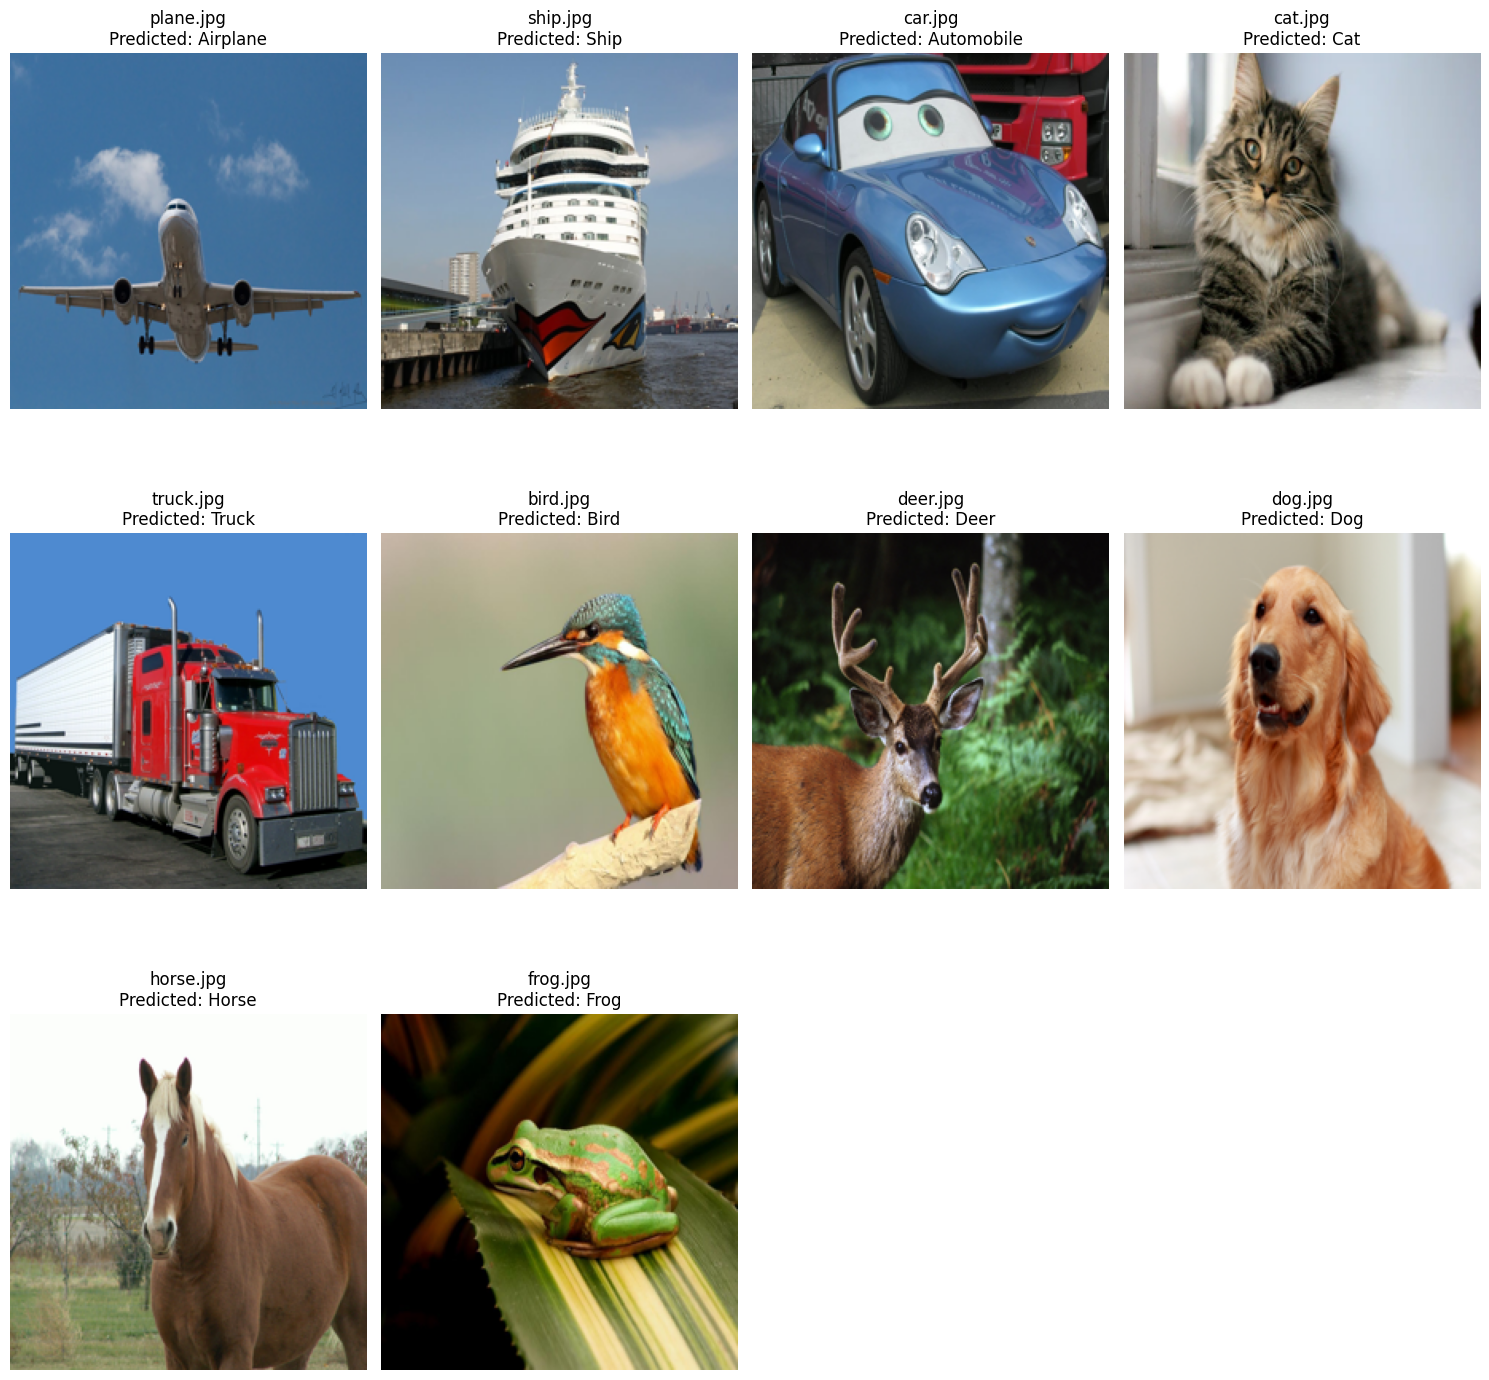

Done!


In [ ]:
def preprocess_image(image_path):
    try:
        img = Image.open(image_path)
        return img.resize((224, 224))
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(('.png', '.jpg', '.jpeg')):
            image = preprocess_image(img_path)
            if image is not None:
                images.append((image, filename))
    return images

def predict(folder, model, class_names):
    model.to(device)
    model.eval()
    images = load_images_from_folder(folder)
    num_images = len(images)
    cols = 4
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(15, (rows) * 5))
    for i, (image, filename) in enumerate(images):
        if dataset == 'MNIST':
            image = image.convert('L')
        image_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted_class = torch.max(output.data, 1)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray' if dataset == 'MNIST' else None)
        plt.title(f"{filename}\nPredicted: {class_names[predicted_class.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('predicted_images.png', bbox_inches='tight', dpi=300)
    print("Predictions saved as 'predicted_images.png'")
    plt.show()
    plt.close()

optimal_model = VisionTransformer(d_model, num_classes, num_heads, num_layers, mlp_dim)
optimal_model.load_state_dict(torch.load(torch_save_dir, weights_only=True))
if dataset == 'CIFAR10' and CIFAR_testing_dir != "":
    predict(CIFAR_testing_dir, optimal_model, classes)
if dataset == 'MNIST' and MNIST_testing_dir != "":
    predict(MNIST_testing_dir, optimal_model, classes)

print("Done!")